# ...:: From Bern to Mürren ::...

###  An RL agent learning from GIS terrain models


## Libraries

In [3]:
!pip install svgwrite seaborn



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

import sys, os
py_file_location = "/content/gdrive/My Drive/AML6/"
sys.path.append(os.path.abspath(py_file_location))

In [4]:
import svgwrite
from IPython.display import display, SVG
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import time

# Drawing function

In [5]:
palette = sns.color_palette('viridis', 101)
palette = [(int(p[0]*255),int(p[1]*255),int(p[2]*255)) for p in palette]

def draw(base_im, show=True, unit=10, depart=(0,0), goal=(29,9), paths=None, title='default.svg'):

    im = base_im * 100.
    padding = 1.5 * unit
    size_x = (2*padding) + im.shape[0]*unit
    size_y = (2*padding) + im.shape[1]*unit
    dwg = svgwrite.Drawing(py_file_location+'_svg/'+title, size=(size_x, size_y))

    for i in range(im.shape[0]):
        for ii in range(im.shape[1]):

            g = int(im[i,ii])
            rgb = palette[g]
            color = svgwrite.rgb(*rgb)
            x, y = padding + (i*unit), padding + (ii*unit)
            tile = dwg.rect(insert=(x,y), size=(unit,unit)).fill(color)
            dwg.add(tile)

    agent_color = svgwrite.rgb(255, 0, 0)
    stroke = 2.
    t_unit = unit - stroke
    t_size = 3.

    if paths is not None:
        for path in paths:
            points = [(padding + (coo[0] * unit) + (0.5 * unit), padding + (coo[1] * unit) + (0.5 * unit)) for coo in path]
            path = dwg.polyline(points=points, fill="none").stroke(color=agent_color, width=stroke)
            dwg.add(path)

    # departure and goal
    dpt_x, dpt_y = (unit * 0.5) + padding + depart[0] * unit, (unit * 0.5) + padding + depart[1] * unit
    dpt = dwg.circle(center=(dpt_x,dpt_y), r=t_unit*(t_size*0.8)).fill(agent_color).stroke(color="white", width=stroke)
    dwg.add(dpt)

    arr_x, arr_y = (unit * 0.5) + padding + goal[0] * unit, (unit * 0.5) + padding + goal[1] * unit
    pt1 = (arr_x + np.sin(np.deg2rad(60)) * t_unit * t_size, arr_y + np.cos(np.deg2rad(60)) * t_unit * t_size)
    pt2 = (arr_x, arr_y - (t_unit * t_size))
    pt3 = (arr_x - np.sin(np.deg2rad(60)) * t_unit * t_size, arr_y + np.cos(np.deg2rad(60)) * t_unit * t_size)
    points = [pt1, pt2, pt3]
    arrival = dwg.polygon(points=points).stroke(color="white", width=stroke).fill(agent_color)
    dwg.add(arrival)

    if show: display(SVG(dwg.tostring()))
        
    return dwg


# GIS terrain data

In [6]:
py_file_location = ''
import numpy as np
import json
with open(py_file_location+'_json/xyz.json', 'r') as f:
    XYZ = np.array(json.load(f))

FileNotFoundError: [Errno 2] No such file or directory: '_json/xyz.json'

In [54]:
M, N = XYZ.shape
print (XYZ.shape)
XYZ[:5,:5]

(140, 100)


array([[523.977672, 539.99312 , 475.637744, 467.139056, 486.96726 ],
       [482.332096, 478.481776, 463.349048, 477.144312, 469.781432],
       [464.7067  , 461.6889  , 469.733572, 525.134116, 541.054292],
       [513.000856, 535.906096, 517.236852, 474.8283  , 536.011208],
       [565.754564, 569.21222 , 528.871716, 473.350744, 523.126388]])

In [55]:
########### Data preparation
XYZ -= XYZ.min()
XYZ /= XYZ.max()
print (XYZ.min(), XYZ.max())
XYZ[:5,:5]

0.0 1.0


array([[0.0175282 , 0.02203498, 0.00392524, 0.00153369, 0.00711339],
       [0.00580904, 0.00472555, 0.00046717, 0.00434919, 0.00227726],
       [0.00084922, 0.        , 0.00226379, 0.01785363, 0.0223336 ],
       [0.0144393 , 0.02088488, 0.01563132, 0.00369746, 0.02091446],
       [0.02928431, 0.0302573 , 0.01890539, 0.00328167, 0.01728865]])

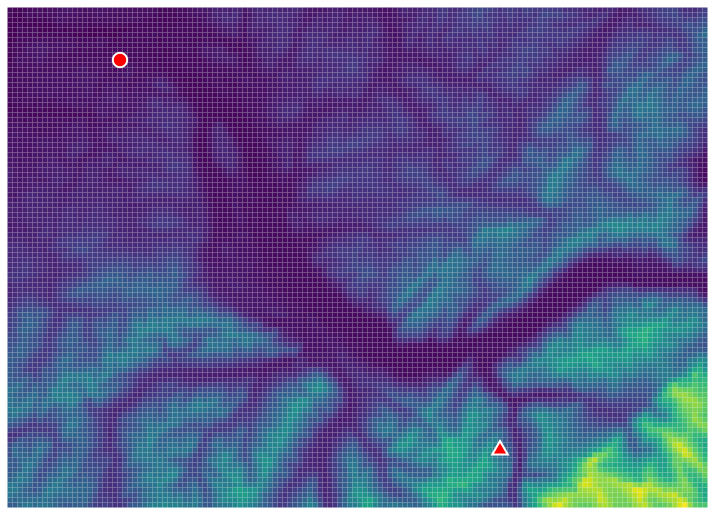

In [56]:
title = "map.svg"
start_pos = (22, 10) # Bern
end_pos =   (98, 88) # Mürren
dwg = draw (XYZ, depart=start_pos, goal=end_pos, unit=5, title=title, show=True)
dwg.save()

# Reinforcement Learning agent
# Chapter 1 : From Bern to Mürren

In [73]:
########### Environment
grid_size = (M, N)
rewards = XYZ
start_pos = (22, 10) # Bern
end_pos =   (98, 88) # Mürren

########### Actions
actions = ['ur', 'ul', 'dr', 'dl']
action_to_index = {action: i for i, action in enumerate(actions)}
max_steps = 250

def get_next_state(state, action):
    x, y = state
    if action == 'ur': x -= 1; y += 1
    elif action == 'ul': x -= 1; y -= 1
    elif action == 'dr': x += 1; y += 1
    elif action == 'dl': x += 1; y -= 1
    return x, y

def training(generalize=False, capture_progression=False, printEvery=5000, num_episodes=100000, max_steps=250):

    # Hyperparameters
    alpha = 0.005           # Learning rate
    gamma = 0.9             # Discount factor
    epsilon = 0.99          # Exploration rate

    Q_table = np.zeros((M, N, len(actions)))

    scores = []
    previous_reached = 0
    reached = 0
    last_z = 0

    for episode in range(num_episodes):
        
        if generalize:
            state = (random.choice(range(int(M/2.)))*2, random.choice(range(int(N/2.)))*2)
        else:
            state = start_pos
            
        path = [state]
        total_reward = 0

        for step in range(max_steps):
            x, y = state

            # Choose action: epsilon-greedy strategy
            if random.uniform(0, 1) < epsilon:
                action = random.choice(actions)  # Explore
            else:
                action = actions[np.argmin(Q_table[x, y])]  # Exploit

            # Get next state
            next_state = get_next_state(state, action)
            path.append(next_state)
            nx, ny = next_state

            # Check if next state is out of bounds
            if nx < 0 or nx >= grid_size[0] or ny < 0 or ny >= grid_size[1]:
                reward = 10000
                total_reward += reward
                Q_table[x, y, action_to_index[action]] += alpha * (
                    reward - Q_table[x, y, action_to_index[action]])
                break

            else:
                distance = abs(nx-end_pos[0]) + abs(ny-end_pos[1]) # Manhattan distance
                reward = distance + (rewards[nx, ny] * distance * 1e+1) # rewards [0, 1]
                total_reward += reward

                Q_table[x, y, action_to_index[action]] += alpha * (
                    reward + gamma * np.min(Q_table[nx, ny]) - Q_table[x, y, action_to_index[action]]
                )

                state = next_state

                if state == end_pos:
                    reached += 1
                    break

        scores.append(total_reward)

        if capture_progression:
            if episode%100==0:
                dwg = draw(XYZ, depart=start_pos, goal=end_pos, unit=5, 
                           paths=[path], show=False, title=f"{int(episode/100.):05d}.svg")
                dwg.save()
                
        if episode%printEvery==0 or episode==num_episodes-1:
            print (f"Episode {episode: 7d}, score {total_reward: 10.1f}, reached {reached - previous_reached: 5d}")
            previous_reached = reached

        # Optionally, decay epsilon to reduce exploration over time
        epsilon = max(0.1, epsilon * 0.999)

    print ("total reached", reached)
    
    return Q_table, scores

In [64]:
t0 = time.time()
Q_table_1, scores_1 = training(max_steps=250,
                               generalize=False, 
                               capture_progression=False, 
                               printEvery=5000, 
                               num_episodes=125000)
t1 = time.time()
print(f"Total training time : {int((t1-t0)//60)} minutes, {int((t1-t0))%60} seconds")

Episode       0, score    56476.4, reached     0
Episode    5000, score    28487.4, reached     0
Episode   10000, score    45382.5, reached     0
Episode   15000, score    58066.2, reached     0
Episode   20000, score    55629.4, reached     0
Episode   25000, score    39546.1, reached     0
Episode   30000, score    33942.7, reached     0
Episode   35000, score    28144.3, reached     0
Episode   40000, score    34654.9, reached     0
Episode   45000, score    49187.1, reached     0
Episode   50000, score    29774.1, reached     0
Episode   55000, score    35703.3, reached     0
Episode   60000, score    27292.0, reached     3
Episode   65000, score    11987.5, reached    20
Episode   70000, score    46762.0, reached    94
Episode   75000, score    46063.5, reached   322
Episode   80000, score    26556.8, reached   888
Episode   85000, score    41614.0, reached  1679
Episode   90000, score    41515.0, reached  2450
Episode   95000, score    11851.9, reached  3216
Episode  100000, sco

In [65]:
with open(py_file_location+'_json/Q_table_1.json', 'w') as f:
    json.dump(Q_table_1.tolist(), f)
    print ('Q_table saved.')

Q_table saved.


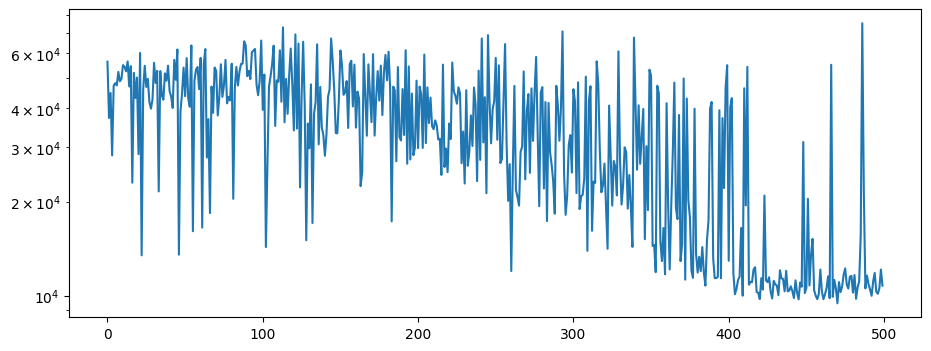

In [68]:
fig = plt.figure(figsize=(11,4))
plt.yscale('log')
_ = plt.plot(scores_1[::250])

In [69]:
Q_table_1, scores_1 = training(max_steps=250,
                               generalize=False, 
                               capture_progression=True, 
                               printEvery=25000, 
                               num_episodes=125000)

Episode       0, score    32668.0, reached     0
Episode   25000, score    46795.6, reached     0
Episode   50000, score    52737.7, reached     0
Episode   75000, score    26723.8, reached   437
Episode  100000, score    40370.5, reached  12082
Episode  124999, score     9704.3, reached  22601
total reached 35120


In [74]:
########### Optimal policy 
def get_optimal_policy(Q_table):
    grid_size = Q_table.shape
    policy = np.full(grid_size[:2], '', dtype=object)

    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            # Choose the action with the minimum Q-value for each state
            best_action_index = np.argmin(Q_table[x, y])
            policy[x, y] = actions[best_action_index]

    return policy

########### Simulate a run using the optimal policy
def simulate_policy(policy, start_state=start_pos, end_state=end_pos):

    state = start_state
    path = [state]
    total_reward = 0
    steps = 0
    last_z = 0

    while state != end_state and steps < max_steps:  # Stop if goal is reached or max steps exceeded
        x, y = state
        action = policy[x, y]
        next_state = get_next_state(state, action)

        # Check for out-of-bounds
        nx, ny = next_state
        if nx < 0 or nx >= grid_size[0] or ny < 0 or ny >= grid_size[1]:
            total_reward += 10000  # Out-of-bounds penalty
            break

        # Add reward for the next state
        z = rewards[nx, ny]
        delta = abs(z - last_z)
        reward = delta
        total_reward += reward
        last_z = z

        state = next_state
        path.append(state)
        steps += 1

    return path, total_reward

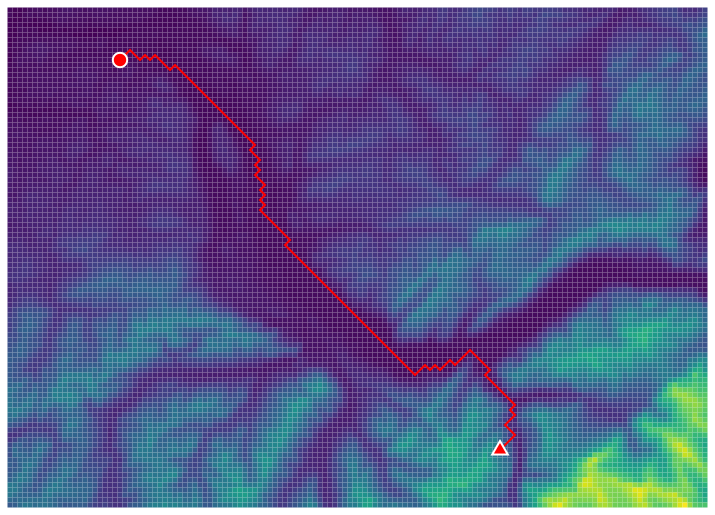

In [112]:
########### Bern to Mürren, optimal path

title = "bern_muerren.svg"
optimal_policy = get_optimal_policy(Q_table_1)
path, _ = simulate_policy(optimal_policy, start_state=start_pos, end_state=end_pos)
dwg = draw (XYZ, depart=start_pos, goal=end_pos, unit=5, paths=[path], title=title, show=False)
dwg.save()

svg_path = "_svg/"+title 
display(SVG(svg_path))

In [78]:
########### Bern to Mürren, learning process (every 100 episodes)

from IPython.display import HTML

video_path = "_mp4/bern_muerren_learning.mp4"  
HTML(f"""
<video width="720" height="520" controls>
  <source src="{video_path}" type="video/mp4">
</video>
""")

# Chapter 2 : (almost) all roads lead to Mürren

In [99]:
t0 = time.time()
Q_table_general, scores_general = training(max_steps=250,
                                           generalize=True, 
                                           capture_progression=False, 
                                           printEvery=100000, 
                                           num_episodes=2000000)
t1 = time.time()
print(f"Total training time : {int((t1-t0)//60)} minutes, {int((t1-t0))%60} seconds")

Episode       0, score    51780.5, reached     0
Episode  100000, score    20962.9, reached  21318
Episode  200000, score    27837.9, reached  48912
Episode  300000, score    29940.4, reached  67690
Episode  400000, score     7394.6, reached  74427
Episode  500000, score     3631.7, reached  75168
Episode  600000, score     7406.0, reached  76466
Episode  700000, score      225.4, reached  76059
Episode  800000, score    36197.1, reached  74872
Episode  900000, score     1953.9, reached  74055
Episode  1000000, score      101.3, reached  73550
Episode  1100000, score     8425.0, reached  72915
Episode  1200000, score    10859.1, reached  72461
Episode  1300000, score     9655.4, reached  71941
Episode  1400000, score    34564.1, reached  71687
Episode  1500000, score    31021.3, reached  71808
Episode  1600000, score     7388.1, reached  71386
Episode  1700000, score    32790.5, reached  71399
Episode  1800000, score     4904.1, reached  71095
Episode  1900000, score    10945.6, reache

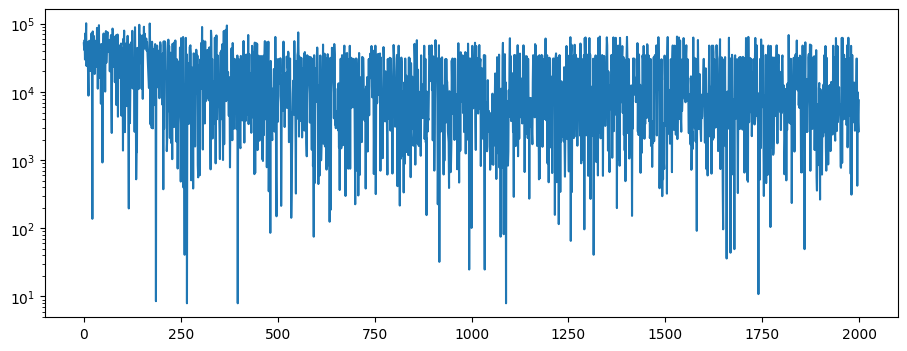

In [100]:
fig = plt.figure(figsize=(11,4))
plt.yscale('log')
_ = plt.plot(scores_general[::1000])

In [101]:
with open(py_file_location+'_json/Q_table_general.json', 'w') as f:
    json.dump(Q_table_general.tolist(), f)
    print ('Q_table saved.')

Q_table saved.


In [102]:
with open('_json/Q_table_general.json', 'r') as f:
    Q_table_general = np.array(json.load(f))

In [110]:
########### (almost) all roads lead to Mürren

max_steps = 300
optimal_policy = get_optimal_policy(Q_table_general)

start_pos_list = []
for i in range(len(XYZ.ravel())):
    x = i%140
    y = i//140
    if x%2!=0 or y%2!=0: continue
    start_pos_list.append((x,y))

paths = []
for pos in start_pos_list:
    path, _ = simulate_policy(optimal_policy, start_state=pos, end_state=end_pos)
    paths.append(path)

title = "all_roads"
dwg = draw (XYZ, depart=start_pos, goal=end_pos, unit=5, paths=paths, title=title+'.svg', show=False)
dwg.save()

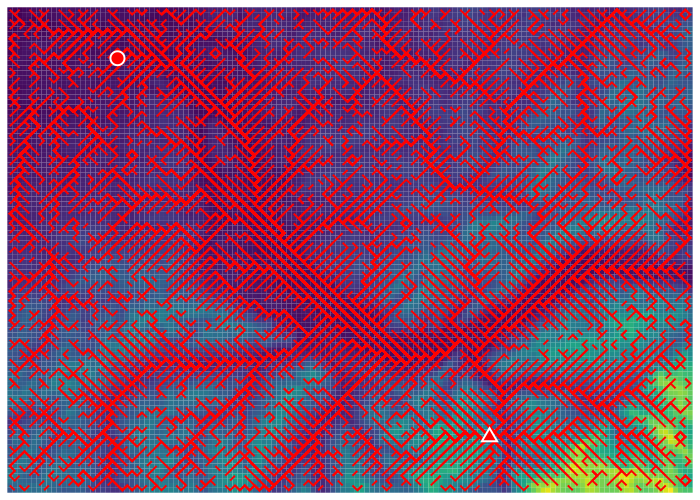

In [111]:
#!rsvg-convert -b white -w 700 -h 500  "_svg/all_roads.svg" > "_png/all_roads.png"
img = Image.open(f"_png/{title}.png")
display(img)

# Annex

In [ ]:
spaths = []

scale = 5
for path in paths:
    s = ""
    for coords in path:
        a, b = coords
        s += str(a*scale)+','+str(b*scale)+' '
    spaths.append(s)

print (len(spaths))

In [ ]:
text = 'let arr = '+str(spaths)
with open('_html/points.js','w') as f:
    f.write(text)